## Lecture 3: Reliability



In [1]:
import os
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import json
from scipy import stats
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt

## Reliability: Data as a model of itself

Here we will use data from the Self Regulation Ontology (SRO) project to assess reliability.  We will focus on one particular measure, the Barratt Impulsiveness Scale, which has a total of 30 items.

First we will look at data from the 150 subjects who performed the entire battery twice.  


In [2]:
SRO_datadir = 'data/SRO'

SRO_origdata = pd.read_csv(
    os.path.join(SRO_datadir, 'orig_subjects_x_items.csv'),
    index_col=0)
SRO_retestdata = pd.read_csv(
    os.path.join(SRO_datadir, 'retest_subjects_x_items.csv'),
    index_col=0)

# combine orig and retest data
SROdata = SRO_origdata.join(SRO_retestdata, lsuffix='_orig', rsuffix='_retest')

# extract BIS-11 survey
BISdata = SROdata[[col for col in SROdata.columns if 'bis11_survey' in col]]
print(BISdata.shape)


(522, 60)


In [3]:
# compute total scores for each measure

BISdata['mean_test1'] = BISdata[[col for col in BISdata if '_orig' in col]].mean(1)
BISdata['mean_test2'] = BISdata[[col for col in BISdata if '_retest' in col]].mean(1)

BISdata_test_retest = BISdata.dropna()


/Users/poldrack/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/poldrack/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0, 0.5, 'BIS11 Overall - Retest score')

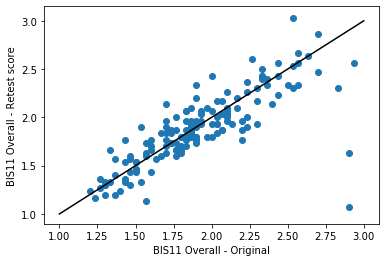

In [4]:
# create a scatter plot for test vs retest data
plt.scatter(BISdata_test_retest['mean_test1'], 
            BISdata_test_retest['mean_test2'])
plt.plot([1, 3], [1, 3], color='black')
plt.xlabel('BIS11 Overall - Original')
plt.ylabel('BIS11 Overall - Retest score')


There are clearly a couple of outliers here, but in general the scores seem fairly consistent between the two tests. We can quantify this using the Pearson correlation:

In [5]:
retest_reliability = np.corrcoef(BISdata_test_retest['mean_test1'], BISdata_test_retest['mean_test2'])[0, 1]
retest_reliability

0.7816743533365371

## Split-half reliability

In the previous case, we had two overall scores for each individual.  However, those two scores were based on responses over a set of 30 total items.  Another way to assess reliability would be to randomly split those items into half, and look at the correlation between the two splits.

In order to make the dataset clearer, we will load the actual text for each of the items (which are stored in a metadata file in the JSON format), and use those as variable names in the data frame.

In [6]:
# set up the item level data for BIS-11 in the original sample

BIS11_itemdata = SRO_origdata[[col for col in SRO_origdata.columns if 'bis11_survey' in col]].dropna()
BIS11_itemdata.shape

## first load item metadata
with open(os.path.join(SRO_datadir, 'bis11_survey.json')) as f:
    bis11_metadata = json.load(f)

# make metadata dict for column names
bis11_itemdict = {}
for i in bis11_metadata:
    if 'bis11' not in i:
        continue
    colname_split = i.split('survey_')
    colname = 'bis11_survey.%02.f' % (int(colname_split[1]))
    
    bis11_itemdict[colname] = bis11_metadata[i]['Description']

BIS11_itemdata = BIS11_itemdata.rename(columns=bis11_itemdict)

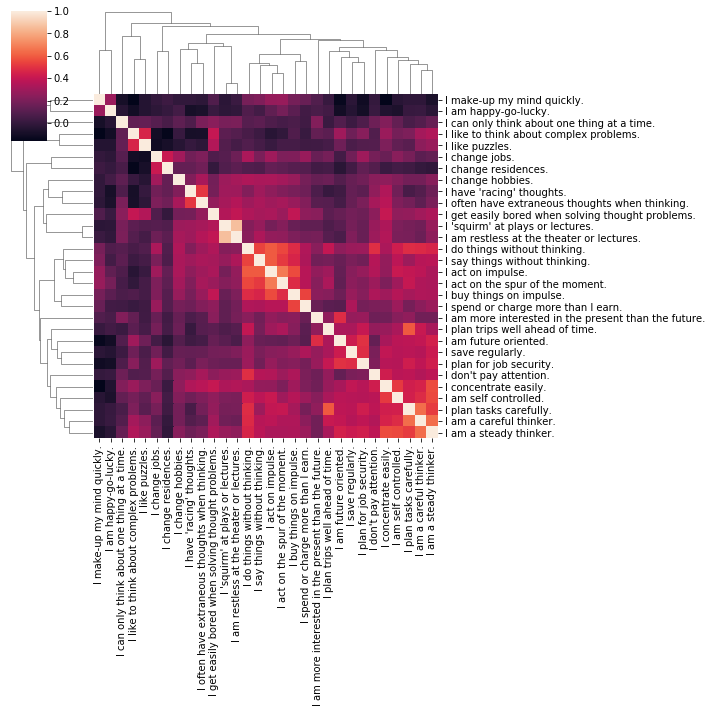

In [7]:
# Compute the correlation matrix across pairs items
cc = BIS11_itemdata.corr()

# display a cluster map

sns.clustermap(cc)

Let's look at the split-half reliability of these items.  The basic idea is as follows:

- split the data into two sets of a particular size (randomly)
- assess the correlation between the splits


In [8]:
#here's a very simple implementation of split-half reliability
#this is a NON-boostrapping version

def get_correlation(data_by_trial, num_trials=None, 
                    num_splits=1000, random_seed=0,
                    statfunc=None):
    """arguments:
          data_by_trial (numpy array): the data
             assumes a tensor with structure is (observation units, trials)
             - e.g. (subjects, trials), or (items, trials)
             
          num_trials(nonnegative integer): how many trials to consider (None for all)
          
          num_splits (nonnegative integer): how many splits of the data to make

          random_seed (nonnegative integer): seed to use for random number generation (None for time-based seed)
          
          statfunc: (function): an arbitrary statistical function that returns a scalar (None for pearson r)
          
       returns:
          array of length num_splits
    """

    # if it's a pandas data frame then convert to numpy array
    if isinstance(data_by_trial, pd.DataFrame):
        data_by_trial = data_by_trial.values

    #get total number of trials
    num_total_trials = data_by_trial.shape[1]
    
    if num_trials is None:
        num_trials = num_total_trials

    #you better not ask for more trials than you actually have
    assert num_trials <= num_total_trials,\
        "You asked for %d trials but there's only %d" % (num_trials, num_total_trials)
    
    #we want to make sure that while we select groups of trials basically randomly,
    #that we can still exactly reproduce our results later
    #so to do this, we use a constructed random number generator to select trial groups
    #and seed the generator with seed = 0 (could be any non-negative integer, but the seed
    #*must* be set for this to be reproducible
    random_number_generator = np.random.RandomState(seed=random_seed)

    corrvals = []
    for split_index in range(num_splits):
        #construct a new permutation of the trial indices
        perm =  random_number_generator.permutation(num_total_trials)
    
        #take the first num_trials/2 and second num_trials/2 pieces of the data
        first_half_of_trial_indices = perm[:int(num_trials / 2)]
        second_half_of_trial_indices = perm[int(num_trials / 2): num_trials]
        
        #mean over trial dimension
        mean_first_half_of_trials = data_by_trial[
            :, first_half_of_trial_indices].mean(axis=1)

        mean_second_half_of_trials = data_by_trial[
            :, second_half_of_trial_indices].mean(axis=1)
        
        #compute the correlation between the means
        if statfunc is None:
            corrval = stats.pearsonr(mean_first_half_of_trials, 
                                 mean_second_half_of_trials)[0]
        else:
            corrval = statfunc(mean_first_half_of_trials, 
                                 mean_second_half_of_trials)
        #add to the list
        corrvals.append(corrval)
        
    return np.array(corrvals)

In [9]:
corrvals = get_correlation(BIS11_itemdata)
np.mean(corrvals)

0.7943460948445455

Here we are using all of the items, but we can also see what happens when we only use a subset of items. 

In [10]:
split_half_by_num_trials = pd.DataFrame(
    {'ntrials': [i for i in range(4, 31, 2)]})


for idx in split_half_by_num_trials.index:
    corrs = get_correlation(BIS11_itemdata,
                            split_half_by_num_trials.loc[idx, 'ntrials'])
    split_half_by_num_trials.loc[idx, 'meancorr'] = np.mean(corrs)
    

Text(0, 0.5, 'Reliability')

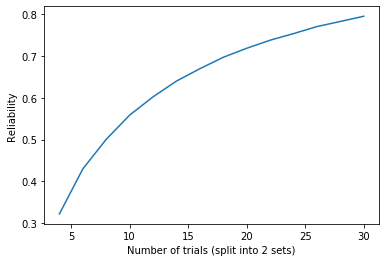

In [11]:
plt.plot(split_half_by_num_trials.ntrials, split_half_by_num_trials.meancorr)
plt.xlabel('Number of trials (split into 2 sets)')
plt.ylabel('Reliability')


This relation between the number of measurements and the split-half reliability follows a lawful relationship, known as the *Spearman-Brown prophecy* formula:

$$
\rho_k = \frac{k * \rho}{1 + (k-1)*\rho}
$$

where $\rho$ is the reliability obtained for a particular number of trials $t$, and $k$ is the multiple of $t$ for which you wish to determine the estimated reliability.

Here let's take the mean reliability estimated for a total of 4 items, and use it to extrapolate the reliability for larger item sets.


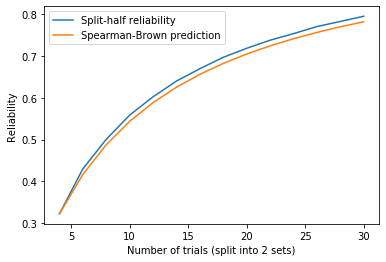

In [12]:
def spearman_brown(rho, k):
    """
    return Spearman-Brown prophecy value
    
    Parameters:
    ----------
    rho: scalar, correlation that is basis for prediction
    k: multiple of # of trials with which rho is computed
    """
    return((k*rho)/(1 + (k-1)*rho))

rho = split_half_by_num_trials['meancorr'].iloc[0]

for idx in split_half_by_num_trials.index:
    k = split_half_by_num_trials.loc[idx, 'ntrials']/4
    split_half_by_num_trials.loc[idx, 'sb'] = spearman_brown(rho, k)
    
plt.plot(split_half_by_num_trials.ntrials, split_half_by_num_trials.meancorr)
plt.plot(split_half_by_num_trials.ntrials, split_half_by_num_trials.sb)
plt.xlabel('Number of trials (split into 2 sets)')
plt.ylabel('Reliability')
plt.legend(['Split-half reliability', 'Spearman-Brown prediction'])

## Reliability in psychometrics

Within psychometrics, there is a tradition of thinking of reliability in terms of the relationship between an observed (or "manifest") variable, and the value of an underlying (or "latent") variable that gives rise to the observed value in combination with some degree of measurement error. 

This is often conceptualized in terms of a *path diagram*, in which arrows reflect influences from the latent variables (shows as ellipses or circles) to the measured variables (shown as boxes).  We will see this in more detail later when we discuss structural equation modeling.

Let's say that we have data from four different measures, of which two are measures of one latent variable (impulsivity) and the other two are measures of another latent variable (impatience).  Here is a path diagram for these variables (To see the code that generated it, look at PathDiagramExample.Rmd in this directory):


![title](path_diagram.png)

In this section we will work with simulated data, so that we know the true underlying scores for each individual. Let's generate some data from this model. We will treat the latent variables as normally distributed, with some degree of correlation.

In [13]:
def make_data(n_subjects=500,
              corr=0.5,
              error_var=0.5,
              scale_data=True,
              latent_seed=None,
              betavals=None):
    """
    create observed measurements from latent variables
    
    Parameters:
    ------------
    n_subjects: int, number of observations
    corr: float, population correlation between latent variables
    error_var: float, rror variance
    scale_data: bool, should we scale the variables?
    latent_seed: int or None, if set, will generate the same latent values each time (with different noise)
    betavals: dict, beta values for pairs of latent and observed variables
    """
    
    # create latent variables - multivariate normal with specified correlation

    if latent_seed is not None:
        np.random.seed(12345)
    latents = np.random.multivariate_normal(mean=[0, 0], 
                                            cov=[[1, corr], [corr, 1]],
                                            size=n_subjects)
    if scale_data:
        latents = scale(latents)

    df = pd.DataFrame(latents, columns=['impulsivity', 'impatience'])

    # create matrix to project latents into observed

    beta = pd.DataFrame(np.zeros((2, 4)), 
                        columns=['BIS', 'UPPS-P', 'Kirby', 'Bickel'],
                        index=df.columns)
    if betavals is None:
        betavals = {('impulsivity', 'BIS'): 1,
                    ('impulsivity', 'UPPS-P'): 1,
                    ('impatience', 'Bickel'): 1,
                    ('impatience', 'Kirby'): 1}
    for b in betavals:
        beta.loc[b[0], b[1]] = betavals[b]

    # create measurement noise, assume all variables have equal noise
    np.random.seed()  # ensure different noise each time
    measurement_noise = np.random.multivariate_normal(
        mean=[0, 0, 0, 0], 
        cov=np.eye(4)*error_var,
        size=n_subjects)

    # create observed data
    observed = df.dot(beta) + measurement_noise

    if scale_data:
        observed = (observed - observed.mean(axis=0)) / observed.std(axis=0)

    df = result = pd.concat([df, observed], axis=1)

    return(df)

In [14]:
df = make_data(latent_seed=123345)
df.head()

,impulsivity,impatience,BIS,UPPS-P,Kirby,Bickel
0,-0.077887,0.377001,-0.234852,0.106830,0.334554,0.335527
1,0.720615,0.129221,0.978236,-0.734433,0.837982,-0.298757
2,-2.440260,-1.062950,-1.782710,-2.177061,-1.340507,-1.157969
3,-0.238764,0.016280,-0.053007,-0.797596,-0.101339,-0.359285
4,-1.318268,-0.088177,-0.231803,-0.778725,0.710321,0.590437


Let's plot a heatmap of the correlations between latent and observed values

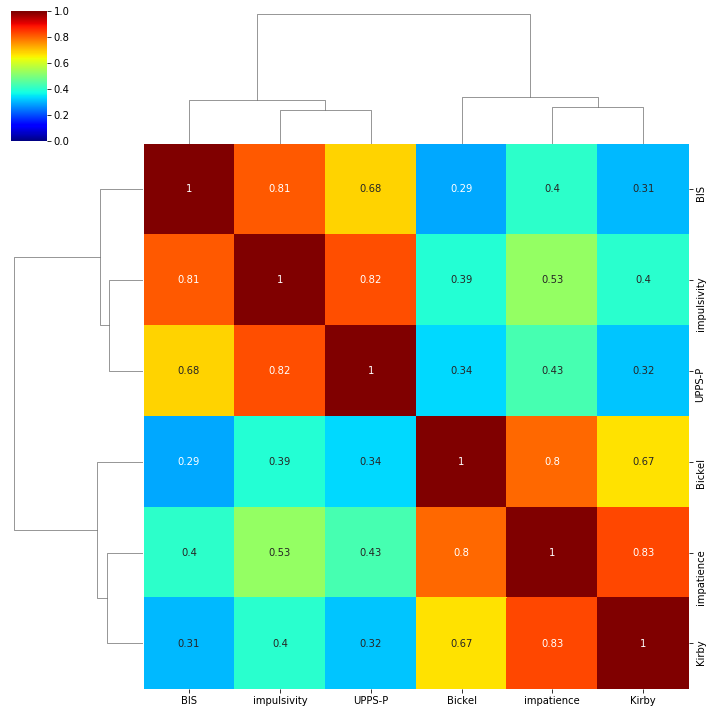

In [15]:
sns.clustermap(df.corr(), annot=True, vmin=0, cmap='jet')

What is the reliability of the measures for each latent?

In [16]:
rho_impulsivity = df[['BIS', 'UPPS-P']].corr().iloc[0, 1]
print('Impulsivity:', rho_impulsivity)

rho_impatience = df[['Kirby', 'Bickel']].corr().iloc[0, 1]
print('Impatience:', rho_impatience)

Impulsivity: 0.6836821379718562
Impatience: 0.6690335341584357


## Attenuation

Error variance in our measures will *attenuate* the correlation between measures.  In this example, let's say that we wanted to estimate the correlation between impulsivity and impatience using the BIS and Kirby measures.  In this case, we know the true correlations of the latent variables:

In [17]:
rho_impulsivity_impatience = df[['impulsivity', 'impatience']].corr().iloc[0, 1]
rho_impulsivity_impatience

0.5289766901235785

What do we see when we compare the two (noisy) measures?


In [18]:
rho_BIS_Kirby = df[['BIS', 'Kirby']].corr().iloc[0,1]
rho_BIS_Kirby

0.30794531064761554

We see here that the correlation between the measures is smaller than the correlation between their true scores.  We can correct for this attenuation using Spearman's formula:

$$
\rho_{T_Y, T_{Y'}} = \frac{\rho_{Y, Y'}}{\sqrt{\rho_Y \rho_{Y'}}}
$$

That is, the observed correlation is attenuated by the square root of the product of the reliabilities of the individual variables. We can see this with our measures:

In [19]:
rho_BIS_Kirby_corrected = rho_BIS_Kirby / np.sqrt(rho_impatience * rho_impulsivity)
rho_BIS_Kirby_corrected

0.45532608905494026

We see that this is much closer to the true correlation between the latent variables.

There is a flip side to this effect: The true correlation between two variables cannot exceed the product of the reliabilities of those measures. This became an issue in a paper published in 2009 titled [Puzzlingly High Correlations in fMRI Studies of Emotion, Personality, and Social Cognition](https://www.ncbi.nlm.nih.gov/pubmed/26158964) by Ed Vul and colleagues.  This paper pointed out that many fMRI studies had published correlations between brain and behavior that were well above 0.8, which was inconsistent with the known reliabilities of both fMRI signals and most behavioral measures.

## Test-retest reliability

We can also view test-retest reliability through the lens of classical test theory.

Let's compare this what we see if we were to collect a new dataset with the same latent variables but different noise:


In [20]:
df_retest = make_data(latent_seed=123345)

retest_correlations = pd.Series(index=['BIS', 'UPPS-P', 'Kirby', 'Bickel'], 
                                dtype=float)

for i in retest_correlations.index:
    retest_correlations[i] = np.corrcoef(df[i], df_retest[i])[0,1]

retest_correlations

BIS       0.672219
UPPS-P    0.693936
Kirby     0.645518
Bickel    0.667831
dtype: float64

These are very close to the reliabilities that we estimated above by comparing the two tests - unsurprisingly, since all of these were generated by simply adding the same kind of noise to the latents. 

In the former case we used Pearson correlation to compute the reliability.  The Pearson coefficient assesses the degree to which the variables are linearly related, but doesn't penalize for different means or slope other than one.  That it, it assesses how well the following model describes the data:

$$
y = slope * X + intercept
$$

In other cases, we might want to hold our measurements to a higher standard, such as $y = X$ (perfect agreement) or $y = X + intercept$ (consistency with a mean offset but $slope = 1$). The *intraclass correlation coefficient* is commonly used for this purpose. There are many different forms of the ICC - here we will focus on ICC(3,1), which is commonly used to assess retest reliability:

$$
ICC(3,1) = \frac{MS_{subjects} - MS_{error}}{MS_{subjects} + MS_{error}}
$$

for the specific version with two measurements for each subject.  

In [21]:
# adapted from https://github.com/nipy/nipype/blob/f2bbcc917899c98102bdeb84db61ea4b84cbf2f5/nipype/algorithms/icc.py#L29

def ICC_rep_anova(Y, verbose=True):
    '''
    the data Y are entered as a 'table' ie subjects are in rows and repeated
    measures in columns
    One Sample Repeated measure ANOVA
    Y = XB + E with X = [FaTor / Subjects]
    '''

    [nb_subjects, nb_conditions] = Y.shape
    dfc = nb_conditions - 1
    dfe = (nb_subjects - 1) * dfc
    dfr = nb_subjects - 1

    # Compute the repeated measure effect
    # ------------------------------------

    # Sum Square Total
    mean_Y = np.mean(Y)
    SST = ((Y - mean_Y)**2).sum()

    # create the design matrix for the different levels
    x = np.kron(np.eye(nb_conditions), np.ones((nb_subjects, 1)))  # sessions
    x0 = np.tile(np.eye(nb_subjects), (nb_conditions, 1))  # subjects
    X = np.hstack([x, x0])

    # Sum Square Error
    predicted_Y = np.dot(np.dot(np.dot(X, np.linalg.pinv(np.dot(X.T, X))), X.T), Y.flatten('F'))
    residuals = Y.flatten('F') - predicted_Y
    SSE = (residuals**2).sum()

    residuals.shape = Y.shape

    MSE = SSE / dfe

    # Sum square session effect - between colums/sessions
    SSC = ((np.mean(Y, 0) - mean_Y)**2).sum() * nb_subjects
    MSC = SSC / dfc / nb_subjects

    session_effect_F = MSC / MSE

    # Sum Square subject effect - between rows/subjects
    SSR = SST - SSC - SSE
    MSR = SSR / dfr

    # ICC(3,1) = (mean square subjeT - mean square error) /
    #            (mean square subjeT + (k-1)*-mean square error)
    ICC = (MSR - MSE) / (MSR + dfc * MSE)

    e_var = MSE  # variance of error
    r_var = (MSR - MSE) / nb_conditions  # variance between subjects
    if verbose:
        print('ICC:', ICC)
        print('r:', np.corrcoef(Y.T)[0, 1])
    return ICC

In [22]:
Y = pd.DataFrame({'orig': df['BIS'], 'retest': df_retest['BIS']})

_ = ICC_rep_anova(Y.values)

ICC: 0.6722189738937108
r: 0.6722189738937107


In this case we see that the ICC is exactly the same as the Pearson correlation, because the values have the same variance. However, because the ICC uses a pooled variance whereas the Pearson R scales separately by the variance of each variable, the ICC will differ if the variances differ:

In [23]:
Y['retest'] = Y['retest'] * 2

_ = ICC_rep_anova(Y.values)

ICC: 0.5377751791149686
r: 0.6722189738937107


The choice of when to use ICC versus Pearson's r depends on the interpretation that one wants.  If you simply care about the degree of shared variance without requiring that the measures share the same metric or variance, then Pearson's r is appropriate. However, depending on the nature of the dataset and the degree to which one wishes to assess different kinds of relationships between the tests (e.g. consistency vs. agreement), one might instead select the appropriate version of ICC.

For more, see:

McGraw, K. O., & Wong, S. P. (1996). Forming inferences about some intraclass correlation coefficients. Psychological Methods, 1(1), 30–46. doi:10.1037/1082-989x.1.1.30 
